# Artistic Resonance Unveiled: Unleashing AI to Identify the Echoes of Renowned Artists in Your Paintings!
My paintings are similar to the works of which artist? In this project, I have designed and trained a model that is able to determine which artist's work my painting resembles.
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg"/>

## Importing dependencies

In [1]:
import torch
from tqdm.auto import tqdm
import numpy as np
import random
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from timeit import default_timer as timer
from torch import nn
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub, quantize_dynamic
from collections import OrderedDict
import torch.optim as optim
import pandas as pd

## Some useful functions from Daniel Bourke
https://github.com/mrdbourke

In [2]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# def pred_and_plot_image(
#     model: torch.nn.Module,
#     image_path: str,
#     class_names: List[str] = None,
#     transform=None,
#     device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
# ):
#     """Makes a prediction on a target image with a trained model and plots the image.

#     Args:
#         model (torch.nn.Module): trained PyTorch image classification model.
#         image_path (str): filepath to target image.
#         class_names (List[str], optional): different class names for target image. Defaults to None.
#         transform (_type_, optional): transform of target image. Defaults to None.
#         device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

#     Returns:
#         Matplotlib plot of target image and model prediction as title.

#     Example usage:
#         pred_and_plot_image(model=model,
#                             image="some_image.jpeg",
#                             class_names=["class_1", "class_2", "class_3"],
#                             transform=torchvision.transforms.ToTensor(),
#                             device=device)
#     """

#     # 1. Load in image and convert the tensor values to float32
#     target_image = torchvision.io.read_image(
#         str(image_path)).type(torch.float32)

#     # 2. Divide the image pixel values by 255 to get them between [0, 1]
#     target_image = target_image / 255.0

#     # 3. Transform if necessary
#     if transform:
#         target_image = transform(target_image)

#     # 4. Make sure the model is on the target device
#     model.to(device)

#     # 5. Turn on model evaluation mode and inference mode
#     model.eval()
#     with torch.inference_mode():
#         # Add an extra dimension to the image
#         target_image = target_image.unsqueeze(dim=0)

#         # Make a prediction on image with an extra dimension and send it to the target device
#         target_image_pred = model(target_image.to(device))

#     # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
#     target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

#     # 7. Convert prediction probabilities -> prediction labels
#     target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

#     # 8. Plot the image alongside the prediction and prediction probability
#     plt.imshow(
#         target_image.squeeze().permute(1, 2, 0)
#     )  # make sure it's the right size for matplotlib
#     if class_names:
#         title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     else:
#         title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     plt.title(title)
#     plt.axis(False)


def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


# def download_data(source: str,
#                   destination: str,
#                   remove_source: bool = True) -> Path:
#     """Downloads a zipped dataset from source and unzips to destination.

#     Args:
#         source (str): A link to a zipped file containing data.
#         destination (str): A target directory to unzip data to.
#         remove_source (bool): Whether to remove the source after downloading and extracting.

#     Returns:
#         pathlib.Path to downloaded data.

#     Example usage:
#         download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                       destination="pizza_steak_sushi")
#     """
#     # Setup path to data folder
#     data_path = Path("data/")
#     image_path = data_path / destination

#     # If the image folder doesn't exist, download it and prepare it...
#     if image_path.is_dir():
#         print(f"[INFO] {image_path} directory exists, skipping download.")
#     else:
#         print(f"[INFO] Did not find {image_path} directory, creating one...")
#         image_path.mkdir(parents=True, exist_ok=True)

#         # Download pizza, steak, sushi data
#         target_file = Path(source).name
#         with open(data_path / target_file, "wb") as f:
#             request = requests.get(source)
#             print(f"[INFO] Downloading {target_file} from {source}...")
#             f.write(request.content)

#         # Unzip pizza, steak, sushi data
#         with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
#             print(f"[INFO] Unzipping {target_file} data...")
#             zip_ref.extractall(image_path)

#         # Remove .zip file
#         if remove_source:
#             os.remove(data_path / target_file)

#     return image_path


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# ---------------------------------------------------------------------------------------------------

In [16]:
import os
from PIL import Image

# Define the directory where your class folders are located
class_dir = 'dataset/dataset/images/images/'

for class_name in os.listdir(class_dir):
    class_path = os.path.join(class_dir, class_name)

    # Loop through each image in the class folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Open the image using PIL
        img = Image.open(image_path)

        # Check if any dimension of the image is 1
        if 1 in img.size:
            # Delete the image if it has a dimension equal to 1
            os.remove(image_path)
            print(f"Deleted {image_path}")

print("Done deleting 1-dim images.")

Done deleting 1-dim images.


## Importing Data
I gathered data of 10 most famous artists from kaggle. I have around 70 pictures of each artist and I set them to gray-scale to get better performance on my gpu.

In [56]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os

class ArtDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.food_categories = sorted(os.listdir(dataset_path))
        self.class_to_idx = {category: i for i, category in enumerate(self.food_categories)}
        self.images, self.labels = self._load_dataset()
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]

        image = Image.open(image_path)
        
        if image.mode == 'L':
            image = image.convert('RGB')

        
        
        # Resize image to 3x256x256
        image = self.transform(image)

        return image, torch.tensor(label)

    def _load_dataset(self):
        dataset = []
        labels = []

        for category_idx, category in enumerate(tqdm(self.food_categories)):
            category_path = os.path.join(self.dataset_path, category)
            image_files = os.listdir(category_path)

            # Exclude the .DS_Store file if it exists
            if ".DS_Store" in image_files:
                image_files.remove(".DS_Store")

            for image_file in image_files:
                image_path = os.path.join(category_path, image_file)
                dataset.append(image_path)
                labels.append(category_idx)  # Assign category index as label

        return dataset, labels


dataset_path = r"dataset\dataset\images\images"
art_dataset = ArtDataset(dataset_path)

# Get an image and label from the dataset
image, label = art_dataset[0]

# Print the number of classes
num_classes = len(art_dataset.food_categories)
print("Number of classes:", num_classes)

# Print the number of images in the dataset
num_images = len(art_dataset)
print("Number of images:", num_images)

# Verify the size of the image tensor
print("Image shape:", image.shape)


Number of classes: 10
Number of images: 2416
Image shape: torch.Size([3, 128, 128])


## Setting a Limit For GPU

In [57]:
# Set the maximum memory limit in bytes (2 GB in this case)
max_memory_limit = 2 * 1024 * 1024 * 1024  # 2 GB

initial_memory_allocated = torch.cuda.memory_allocated()
print("Initial memory allocated:", initial_memory_allocated)

# Empty the GPU cache to release unused memory
torch.cuda.empty_cache()

# Set the memory limit
torch.cuda.set_per_process_memory_fraction(0.8)  # Set to 60% of GPU memory

# Check the memory usage after operations
final_memory_allocated = torch.cuda.memory_allocated()
print("Final memory allocated:", final_memory_allocated/1000000)
if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(device))
else:
    print("CUDA is not available")

Initial memory allocated: 1644574208
Final memory allocated: 1644.574208
CUDA is available
GPU: NVIDIA GeForce GTX 1650 Ti


## List Of Supported Artists

In [58]:
artist_categories = sorted(os.listdir(dataset_path))
category_dict = {}

for category_idx, category in enumerate(artist_categories):
    category_dict[category_idx] = category

print(category_dict)


{0: 'Andy_Warhol', 1: 'Claude_Monet', 2: 'Edvard_Munch', 3: 'Henri_Matisse', 4: 'Leonardo_da_Vinci', 5: 'Michelangelo', 6: 'Pablo_Picasso', 7: 'Rembrandt', 8: 'Salvador_Dali', 9: 'Vincent_van_Gogh'}


## Creating Dataloader

In [59]:
import torch
from torch.utils.data import DataLoader, random_split


# Set the desired train-test split ratio
train_ratio = 0.8  # 80% of the data for training, 20% for testing
dataset_size = len(art_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(art_dataset, [train_size, test_size])

# Create data loaders for the training and testing datasets
batch_size = 10  # Set your desired batch size
shuffle = True   # Set to True if you want to shuffle the training data
num_workers = 0  # Set the number of worker processes for loading the data (usually set to the number of CPU cores)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Some Examples Of Dataset  

torch.Size([3, 128, 128])


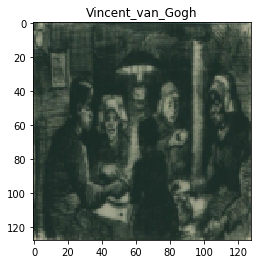

torch.Size([3, 128, 128])


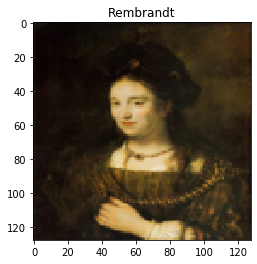

torch.Size([3, 128, 128])


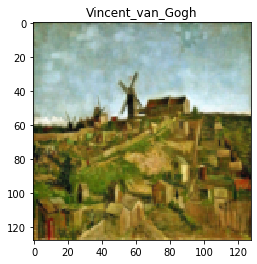

torch.Size([3, 128, 128])


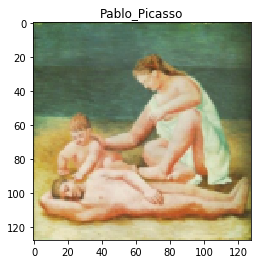

torch.Size([3, 128, 128])


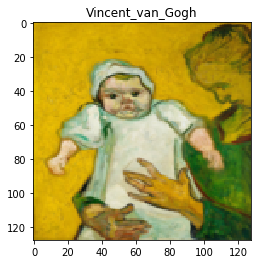

In [60]:
for f1 in range(5):
    index = random.randint(0, len(train_dataset) - 1)
    image, label = train_dataset[index]
    print(image.shape)
    plt.imshow(image.permute(1,2,0).squeeze().detach().numpy())
    plt.title(category_dict[int(label)])
    plt.show()

## Creating a model
I created different models but for training I used the first one.

In [71]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [62]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 32, kernel_size=3, padding=1)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
            
        ]))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(65536, 512)),
            ('relu3', nn.ReLU(inplace=True)),
            ('dropout', nn.Dropout()),
            ('fc2', nn.Linear(512, num_classes))
        ]))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
class QuantizedCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(QuantizedCNNModel, self).__init__()
        self.quant = QuantStub()
        self.features = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(nn.Linear(16384, 512),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(512, num_classes))
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x
    

## Optimizer and loss function

In [64]:
artists = pd.read_csv('dataset/artists.csv')

artists.shape

(50, 8)

In [65]:
artist_names = ['Andy Warhol', 'Claude Monet', 'Edvard Munch', 'Henri Matisse', 'Leonardo da Vinci', 'Michelangelo', 'Pablo Picasso', 'Rembrandt', 'Salvador Dali', 'Vincent van Gogh']


# Create a boolean mask to select rows that match the artist names
mask = artists['name'].isin(artist_names)

# Rearrange the DataFrame so that rows matching the artist names are at the top
artists = pd.concat([artists[mask], artists[~mask]])

# Now, you have rearranged the artists DataFrame, and you can create artists_choosen
artists_choosen = artists[mask].copy()

# Reset the index of artists_choosen if needed
artists_choosen.reset_index(drop=True, inplace=True)

id_mapping = {
    3: 1,
    5: 2,
    8: 3,
    13: 4,
    26: 5,
    28: 6,
    31: 7,
    37: 8,
    45: 9,
    48: 10
}

# Use the map function to replace the 'id' values

artists_choosen = artists_choosen.rename(columns={'Unnamed: 0': 'id'})
artists_choosen['id'] = artists_choosen['id'].map(id_mapping)


print(artists_choosen.shape)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


(10, 8)


In [66]:
artists_choosen['class_weight'] = artists_choosen.paintings.sum() / (artists_choosen.shape[0] *artists_choosen.paintings)
artists_choosen = artists_choosen[['name' , 'paintings', 'class_weight']]
artists_choosen

,name,paintings,class_weight
0,Claude Monet,73,3.309589
1,Salvador Dali,139,1.738129
2,Vincent van Gogh,877,0.275485
3,Pablo Picasso,439,0.550342
4,Leonardo da Vinci,143,1.689510
5,Henri Matisse,186,1.298925
6,Rembrandt,262,0.922137
7,Edvard Munch,67,3.605970
8,Andy Warhol,181,1.334807
9,Michelangelo,49,4.930612


In [67]:
artist_names = ['Andy Warhol', 'Claude Monet', 'Edvard Munch', 'Henri Matisse', 'Leonardo da Vinci', 'Michelangelo', 'Pablo Picasso', 'Rembrandt', 'Salvador Dali', 'Vincent van Gogh']

# Create a dictionary to map artist names to their class weights
class_weights_mapping = dict(zip(artists_choosen['name'], artists_choosen['class_weight']))

# Sort the artist names alphabetically to match your model's class order
artist_names.sort()

# Create a list of class weights in the order of your model's classes
class_weights = [class_weights_mapping[name] for name in artist_names]

# Now, 'class_weights' contains the class weights in the order of your model's classes
print(class_weights)

[1.3348066298342542, 3.3095890410958906, 3.6059701492537313, 1.2989247311827956, 1.6895104895104895, 4.930612244897959, 0.5503416856492027, 0.9221374045801527, 1.7381294964028777, 0.275484606613455]


In [78]:
num_classes = 10
model = CNNModel(num_classes)

# Define loss function and optimizer
# weight=torch.tensor(class_weights, dtype=torch.float)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [82]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

        if self.verbose:
            if self.early_stop:
                print("Early stopping")

## Training
Accuracy with the test data was around 40% which is reasonable since we have 10 different classes (artists). You may get a higher accuracy with training a bigger model on a better gpu than mine.

In [80]:
device = 'cuda'
epochs = 5
print(torch.cuda.max_memory_allocated())
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch in tqdm(train_data_loader):    
        X, y = batch
        model.train()
        y_pred = model(X.to(device))
        probabilities = torch.sigmoid(y_pred)
        y_new_shape = torch.zeros(len(y), 10)
        for f1 in range(len(y)):
            y_new_shape[f1][y[f1]] = 1
        loss = loss_fn(probabilities.to('cpu'), y_new_shape.to('cpu'))
        val_loss = validate(model, val_loader, criterion)
        # Check for early stopping
        early_stopping(val_loss, model)
        train_loss += loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_loader)
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        model.eval()
        for batch in test_data_loader:
            X, y = batch
            test_pred = model(X.to(device))
            probabilities = torch.sigmoid(test_pred)
            y_new_shape = torch.zeros(len(y), 10)
            for f1 in range(len(y)):
                y_new_shape[f1][y[f1]] = 1
            test_loss += loss_fn(probabilities.to('cpu'), y_new_shape.to('cpu'))
            test_acc += accuracy_fn(y_true=y.to('cpu'),
                            y_pred=test_pred.argmax(dim=1).to('cpu'))
        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)
    print(
        f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
torch.save(model,"model-final.pth")
torch.save(model.state_dict(), "model-final.pkl")


2466658304



Train loss: 2.02105 | Test loss: 2.01888, Test acc: 41.63%




Train loss: 2.03238 | Test loss: 2.02194, Test acc: 41.43%




Train loss: 2.03500 | Test loss: 2.02151, Test acc: 41.63%




Train loss: 2.02387 | Test loss: 2.02515, Test acc: 41.22%




Train loss: 2.07518 | Test loss: 2.12451, Test acc: 10.41%



### I got 50% percent accuracy with colored images and 40% with gray-scale images